In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import os  # Import the os module

# Mount Google Drive
drive.mount('/content/drive')

# Unzip the dataset
!unzip -qn /content/drive/MyDrive/final_dataset.zip -d /content/subset

# List the contents of the folder
print("Files in dataset folder:", os.listdir("/content/subset"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in dataset folder: ['final_dataset']


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import shutil
import warnings
import pandas as pd
import time
import random
import tensorflow as tf


In [ ]:
!pip install opencv-python matplotlib tensorflow pandas


In [ ]:
LOCAL_DATASET_PATH = "subset"
if os.path.exists(LOCAL_DATASET_PATH):
    shutil.rmtree(LOCAL_DATASET_PATH)

SUBSET_PATH = "/content/drive/MyDrive/final_dataset.zip"  # Update with the actual path
os.system(f"unzip -qn {SUBSET_PATH} -d {LOCAL_DATASET_PATH} > /dev/null")

for folder in glob(LOCAL_DATASET_PATH + "/*"):
    for in_folder in glob(folder + "/*"):
        file_name = in_folder.split("/")[-1]
        shutil.move(in_folder, os.path.join(LOCAL_DATASET_PATH, file_name))
    shutil.rmtree(folder)

dataset = pd.read_csv(os.path.join(LOCAL_DATASET_PATH, "dataset.csv"), index_col=[0])
print("Dataset loaded successfully!")


Dataset loaded successfully!


In [ ]:
print("Dataset preview:")
print(dataset.head())
print("Total samples:", len(dataset))


Dataset preview:
  person_id  age complexion genere observation         nir_image  \
0     M0001   11      obese      M         NaN  nir_images/0.png   
1     M0002   11     skinny      F         NaN  nir_images/1.png   
2     M0003   12       slim      F         NaN  nir_images/2.png   
3     M0004   12       slim      F         NaN  nir_images/3.png   
4     M0005   11     skinny      M         NaN  nir_images/4.png   

          preprocessed_image         mask  acf_bbox_x1  acf_bbox_x2  \
0  preprocessed_images/0.png  masks/0.png          779         1126   
1  preprocessed_images/1.png  masks/1.png          837         1080   
2  preprocessed_images/2.png  masks/2.png          893         1185   
3  preprocessed_images/3.png  masks/3.png          730          985   
4  preprocessed_images/4.png  masks/4.png          770          997   

   acf_bbox_y1  acf_bbox_y2  acf_center_x  acf_center_y  arm_angle  
0          346          672           953           509        5.0  
1        

In [ ]:
def create_unet_model(input_size=(512, 512, 1)):
    inputs = tf.keras.layers.Input(input_size)
    # Encoding
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)

    # Decoding
    u1 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c3)
    c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u2 = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c4)
    c5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = tf.keras.models.Model(inputs, outputs)
    return model

# Create and compile the model
unet = create_unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("U-Net model created!")



U-Net model created!


In [ ]:
# Save the model for future use
unet.save("/content/unet_model.h5")
print("Model saved as /content/unet_model.h5")


Model saved as /content/unet_model.h5


In [ ]:
def obtain_subset(dataset):
    images = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["preprocessed_image"].values]
    masks = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["mask"].values]
    x_centers = [int(x) for x in dataset["acf_center_x"].values]
    y_centers = [int(y) for y in dataset["acf_center_y"].values]
    angles = [int(angle) for angle in dataset["arm_angle"].values]
    ids = [int(id) for id in dataset.index]

    # Normalize angles and avoid similarity between 0 and 180
    for idx, angle in enumerate(angles):
        if angle > 170:
            angles[idx] = 0

    return images, masks, x_centers, y_centers, angles, ids


In [ ]:
# Define obtain_subset
def obtain_subset(dataset):
    images = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["preprocessed_image"].values]
    masks = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["mask"].values]
    x_centers = [int(x) for x in dataset["acf_center_x"].values]
    y_centers = [int(y) for y in dataset["acf_center_y"].values]
    angles = [int(angle) for angle in dataset["arm_angle"].values]
    ids = [int(id) for id in dataset.index]

    # Normalize angles and avoid similarity between 0 and 180
    for idx, angle in enumerate(angles):
        if angle > 170:
            angles[idx] = 0

    return images, masks, x_centers, y_centers, angles, ids

# Dataset splitting
NUM_TRAIN_SAMPLES = int(len(dataset) * 0.70)
NUM_VAL_SAMPLES = int(len(dataset) * 0.20)
NUM_TEST_SAMPLES = len(dataset) - NUM_TRAIN_SAMPLES - NUM_VAL_SAMPLES

train_images, train_masks, train_acf_x_centers, train_acf_y_centers, train_angles, train_ids = obtain_subset(dataset[:NUM_TRAIN_SAMPLES])
val_images, val_masks, val_acf_x_centers, val_acf_y_centers, val_angles, val_ids = obtain_subset(dataset[NUM_TRAIN_SAMPLES:NUM_TRAIN_SAMPLES + NUM_VAL_SAMPLES])
test_images, test_masks, test_acf_x_centers, test_acf_y_centers, test_angles, test_ids = obtain_subset(dataset[NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES:])

print("Dataset split successfully!")


Dataset split successfully!


In [ ]:
# Define preprocessing functions
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

def preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [512, 512])
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize to [0, 1]
    return mask

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), preprocess_mask(y)))
train_dataset = train_dataset.batch(16).shuffle(buffer_size=100).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.map(lambda x, y: (preprocess_image(x), preprocess_mask(y)))
val_dataset = val_dataset.batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
def create_unet_model(input_size=(512, 512, 1)):
    inputs = tf.keras.layers.Input(input_size)
    # Encoding
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)

    # Decoding
    u1 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c3)
    c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u2 = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c4)
    c5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = tf.keras.models.Model(inputs, outputs)
    return model

# Create and compile the model
unet = create_unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model created and compiled!")


Model created and compiled!


In [ ]:
# Train the model
history = unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 92s 416ms/step - accuracy: 0.8380 - loss: 0.2978 - val_accuracy: 0.9200 - val_loss: 0.0047
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 120s 406ms/step - accuracy: 0.8986 - loss: 0.0047 - val_accuracy: 0.9200 - val_loss: 0.0033
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 70s 292ms/step - accuracy: 0.8930 - loss: 0.0040 - val_accuracy: 0.9200 - val_loss: 0.0030
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 79s 272ms/step - accuracy: 0.8902 - loss: 0.0040 - val_accuracy: 0.9200 - val_loss: 0.0030
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 84s 293ms/step - accuracy: 0.8924 - loss: 0.0039 - val_accuracy: 0.9200 - val_loss: 0.0029
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.8972 - loss: 0.0037 - val_accuracy: 0.9200 - val_loss: 0.0029
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 56s 296ms/step - accuracy: 0.8891 - loss: 0.0039 - val_accuracy: 0.9200 - val_loss: 0.0029
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 294ms/step - accuracy: 0.8912 - loss: 0.0038 - val_acc

In [ ]:
val_loss, val_accuracy = unet.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.9095 - loss: 0.0032
Validation Loss: 0.002829589881002903
Validation Accuracy: 0.9199618697166443


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


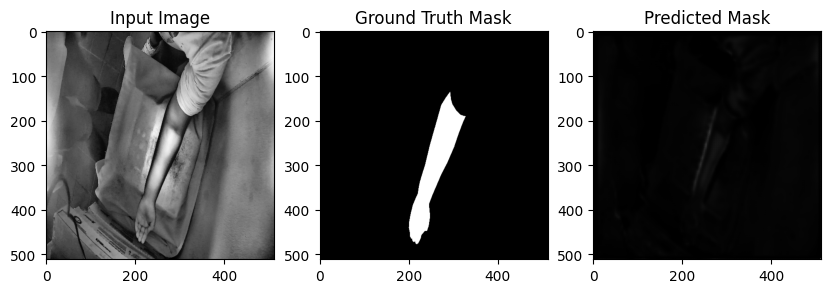

In [ ]:
def predict_and_visualize(model, image_path, mask_path):
    # Preprocess image and mask
    image = preprocess_image(image_path)
    mask = preprocess_mask(mask_path)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    # Predict
    predicted_mask = model.predict(image)[0]  # Remove batch dimension

    # Visualize
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(tf.squeeze(mask), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(tf.squeeze(predicted_mask), cmap='gray')
    plt.show()

# Test on a random sample
random_index = random.randint(0, len(test_images) - 1)
predict_and_visualize(unet, test_images[random_index], test_masks[random_index])


In [ ]:
unet.save("/content/unet_model.h5")
print("Model saved as unet_model.h5")


Model saved as unet_model.h5


In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
def augment(image, mask):
    image = tf.image.random_flip_left_right(image)
    mask = tf.image.random_flip_left_right(mask)
    return image, mask

train_dataset = train_dataset.map(augment).shuffle(buffer_size=100).batch(16).prefetch(tf.data.AUTOTUNE)


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(unet)
tflite_model = converter.convert()
with open("unet_model.tflite", "wb") as f:
    f.write(tflite_model)
print("Model converted to TensorFlow Lite format!")


Saved artifact at '/tmp/tmpo134xyxh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None)
Captures:
  132500488657328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132500488665072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132500488666656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132500488656272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132500488657504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132500434472272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132500434484240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132500434473504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132500434481952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132500434480192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

In [ ]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Preprocess all test images
preprocessed_test_images = [preprocess_image(img) for img in test_images]
preprocessed_test_images = tf.stack(preprocessed_test_images)  # Stack into a tensor


In [ ]:
def preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [512, 512])
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize to [0, 1]
    return mask

preprocessed_test_masks = [preprocess_mask(mask) for mask in test_masks]
preprocessed_test_masks = tf.stack(preprocessed_test_masks)  # Stack into a tensor


In [ ]:
def iou_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    iou = intersection / union
    return iou

# Predict on preprocessed test images
predictions = unet.predict(preprocessed_test_images)

# Threshold predictions to create binary masks
binary_predictions = tf.cast(predictions > 0.5, tf.float32)

# Compute IoU for each sample
ious = [iou_metric(preprocessed_test_masks[i], binary_predictions[i]) for i in range(len(test_images))]
mean_iou = tf.reduce_mean(ious)

print(f"Mean IoU on test dataset: {mean_iou.numpy()}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 865ms/step
Mean IoU on test dataset: 0.0


In [ ]:
print(preprocessed_test_images.shape)
print(preprocessed_test_masks.shape)
print(predictions.shape)


(202, 512, 512, 1)
(202, 512, 512, 1)
(202, 512, 512, 1)


In [ ]:
for i, iou in enumerate(ious):
    print(f"Sample {i+1}: IoU = {iou.numpy():.4f}")
print(f"Overall Mean IoU: {mean_iou.numpy():.4f}")


Sample 1: IoU = 0.0000
Sample 2: IoU = 0.0000
Sample 3: IoU = 0.0000
Sample 4: IoU = 0.0000
Sample 5: IoU = 0.0000
Sample 6: IoU = 0.0000
Sample 7: IoU = 0.0000
Sample 8: IoU = 0.0000
Sample 9: IoU = 0.0000
Sample 10: IoU = 0.0000
Sample 11: IoU = 0.0000
Sample 12: IoU = 0.0000
Sample 13: IoU = 0.0000
Sample 14: IoU = 0.0000
Sample 15: IoU = 0.0000
Sample 16: IoU = 0.0000
Sample 17: IoU = 0.0000
Sample 18: IoU = 0.0000
Sample 19: IoU = 0.0000
Sample 20: IoU = 0.0000
Sample 21: IoU = 0.0000
Sample 22: IoU = 0.0000
Sample 23: IoU = 0.0000
Sample 24: IoU = 0.0000
Sample 25: IoU = 0.0000
Sample 26: IoU = 0.0000
Sample 27: IoU = 0.0000
Sample 28: IoU = 0.0000
Sample 29: IoU = 0.0000
Sample 30: IoU = 0.0000
Sample 31: IoU = 0.0000
Sample 32: IoU = 0.0000
Sample 33: IoU = 0.0000
Sample 34: IoU = 0.0000
Sample 35: IoU = 0.0000
Sample 36: IoU = 0.0000
Sample 37: IoU = 0.0000
Sample 38: IoU = 0.0000
Sample 39: IoU = 0.0000
Sample 40: IoU = 0.0000
Sample 41: IoU = 0.0000
Sample 42: IoU = 0.0000
S

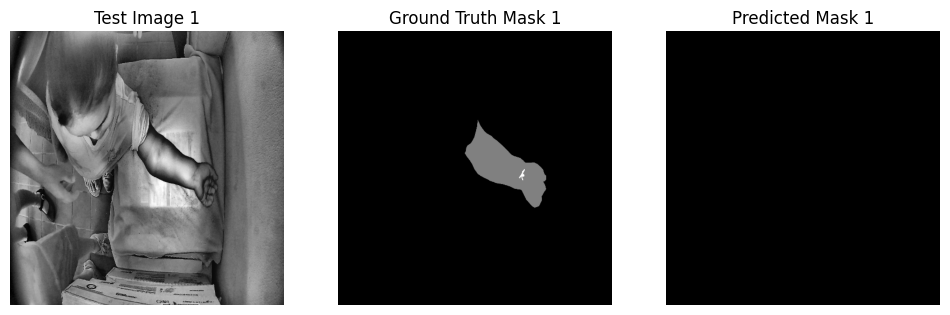

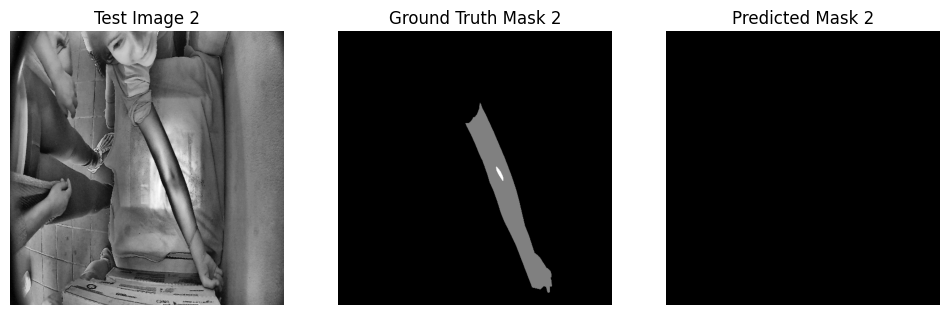

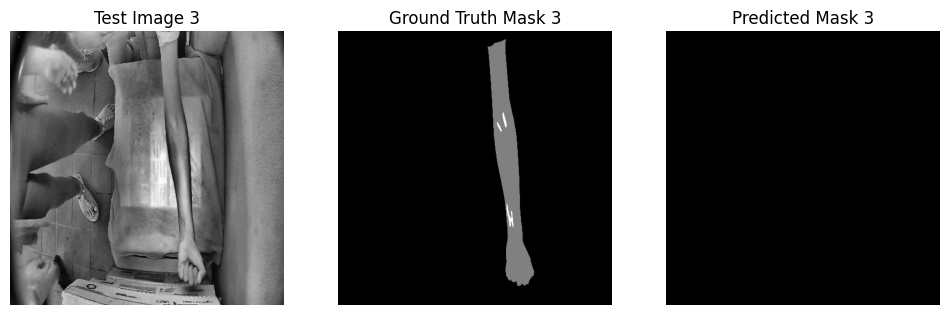

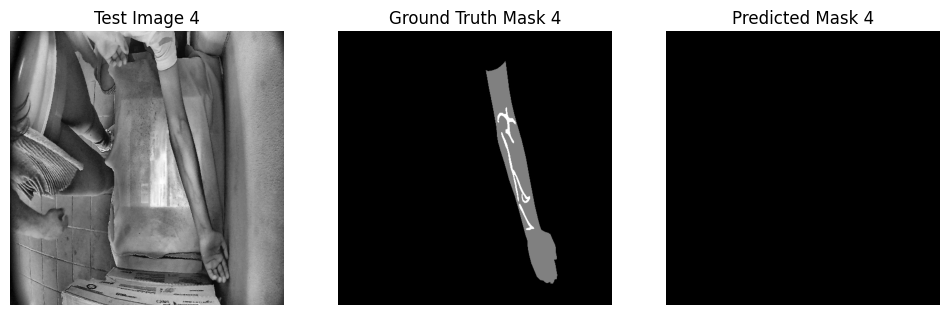

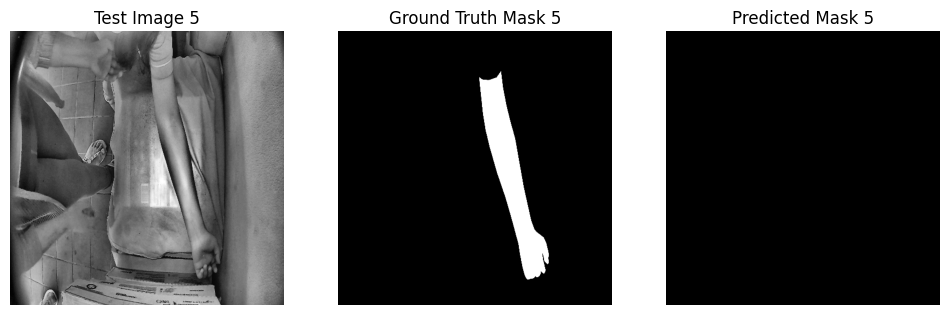

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(image, true_mask, pred_mask, sample_index):
    plt.figure(figsize=(12, 6))

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.title(f"Test Image {sample_index}")
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.axis('off')

    # Display the ground truth mask
    plt.subplot(1, 3, 2)
    plt.title(f"Ground Truth Mask {sample_index}")
    plt.imshow(tf.squeeze(true_mask), cmap='gray')
    plt.axis('off')

    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.title(f"Predicted Mask {sample_index}")
    plt.imshow(tf.squeeze(pred_mask), cmap='gray')
    plt.axis('off')

    plt.show()

# Visualize a few samples
for i in range(5):  # Visualize the first 5 samples
    visualize_sample(preprocessed_test_images[i], preprocessed_test_masks[i], binary_predictions[i], i+1)


In [ ]:
import os

# Create a directory to save predictions
os.makedirs('/content/predictions', exist_ok=True)

# Save the predicted masks as images
for i, pred in enumerate(binary_predictions):
    pred_image = tf.squeeze(pred).numpy() * 255.0  # Convert to [0, 255] range
    cv2.imwrite(f"/content/predictions/prediction_{i+1}.png", pred_image)
print("Predictions saved to /content/predictions/")


Predictions saved to /content/predictions/


Worst-performing sample index: 0, IoU: 0.0000


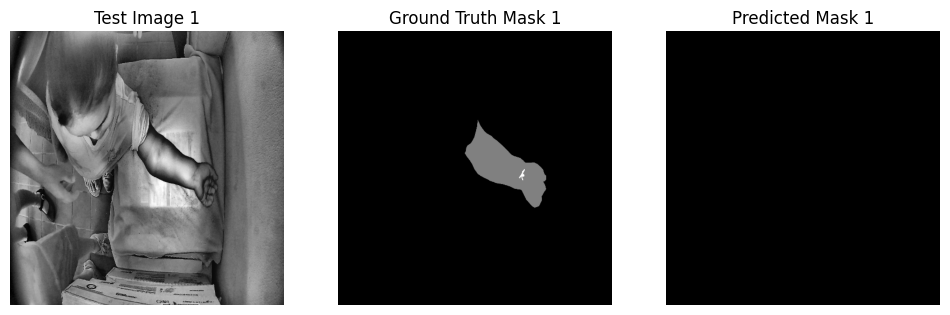

In [ ]:
# Find and display the worst-performing sample
min_iou_index = tf.argmin(ious).numpy()
print(f"Worst-performing sample index: {min_iou_index}, IoU: {ious[min_iou_index].numpy():.4f}")
visualize_sample(preprocessed_test_images[min_iou_index], preprocessed_test_masks[min_iou_index], binary_predictions[min_iou_index], min_iou_index+1)


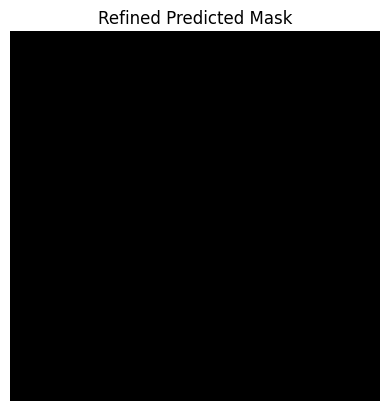

In [ ]:
import cv2
import numpy as np

def refine_mask(mask):
    mask = (mask * 255).astype(np.uint8)  # Convert to uint8
    kernel = np.ones((5, 5), np.uint8)    # Define a kernel
    refined = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return refined

# Refine a sample predicted mask
refined_pred = refine_mask(binary_predictions[0].numpy())
plt.imshow(refined_pred, cmap='gray')
plt.title("Refined Predicted Mask")
plt.axis('off')
plt.show()


In [ ]:
print("Raw predicted mask values (before thresholding):")
print(binary_predictions[0].numpy())


Raw predicted mask values (before thresholding):
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [ ]:
print("Binary predicted mask values (after thresholding):")
print((binary_predictions[0].numpy() > 0.5).astype(np.uint8))


Binary predicted mask values (after thresholding):
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


In [ ]:
dataset = pd.read_csv(os.path.join(LOCAL_DATASET_PATH, "dataset.csv"), index_col=[0])

dataset

,person_id,age,complexion,genere,observation,nir_image,preprocessed_image,mask,acf_bbox_x1,acf_bbox_x2,acf_bbox_y1,acf_bbox_y2,acf_center_x,acf_center_y,arm_angle
0,M0001,11,obese,M,NaN,nir_images/0.png,preprocessed_images/0.png,masks/0.png,779,1126,346,672,953,509,5.0
1,M0002,11,skinny,F,NaN,nir_images/1.png,preprocessed_images/1.png,masks/1.png,837,1080,490,750,959,620,5.0
2,M0003,12,slim,F,NaN,nir_images/2.png,preprocessed_images/2.png,masks/2.png,893,1185,132,424,1039,278,168.0
3,M0004,12,slim,F,NaN,nir_images/3.png,preprocessed_images/3.png,masks/3.png,730,985,431,683,858,557,5.0
4,M0005,11,skinny,M,NaN,nir_images/4.png,preprocessed_images/4.png,masks/4.png,770,997,409,634,884,522,178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,M1006,16,slim,F,NaN,nir_images/2011.png,preprocessed_images/2011.png,masks/2011.png,877,1070,302,493,974,398,177.0
2012,M1007,19,slim,M,NaN,nir_images/2012.png,preprocessed_images/2012.png,masks/2012.png,655,869,433,656,762,545,11.0
2013,M1008,16,slim,M,NaN,nir_images/2013.png,preprocessed_images/2013.png,masks/2013.png,718,972,206,481,845,344,5.0
2014,M1009,16,slim,F,NaN,nir_images/2014.png,preprocessed_images/2014.png,masks/2014.png,850,1093,239,462,972,351,5.0


In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 16

TOTAL_SAMPLES = len(dataset)
print("Total samples:", TOTAL_SAMPLES)

NUM_TRAIN_SAMPLES = int(TOTAL_SAMPLES * 0.70)
NUM_VAL_SAMPLES = int(TOTAL_SAMPLES * 0.20)
NUM_TEST_SAMPLES = int(TOTAL_SAMPLES * 0.10)

print("Number of train images:",NUM_TRAIN_SAMPLES," val images:",NUM_VAL_SAMPLES," test images:",NUM_TEST_SAMPLES)

def obtain_subset(dataset):
  images = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["preprocessed_image"].values]
  masks = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["mask"].values]
  x_centers = [ int(x) for x in dataset["acf_center_x"].values]
  y_centers = [ int(y) for y in dataset["acf_center_y"].values]
  angles = [ int(angle) for angle in dataset["arm_angle"].values]
  ids = [ int(id) for id in dataset.index]

  # Normalize angles and avoid similarity between 0 and 180
  for idx, angle in enumerate(angles):
    if angle > 170:
      angles[idx] = 0

  return images, masks, x_centers, y_centers, angles, ids

train_images, train_masks, train_acf_x_centers, train_acf_y_centers, train_angles, train_ids = obtain_subset(dataset[:NUM_TRAIN_SAMPLES])
val_images, val_masks, val_acf_x_centers, val_acf_y_centers, val_angles, val_ids = obtain_subset(dataset[NUM_TRAIN_SAMPLES : NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES])
test_images, test_masks, test_acf_x_centers, test_acf_y_centers, test_angles, test_ids = obtain_subset(dataset[NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES : ])

Total samples: 2016
Number of train images: 1411  val images: 403  test images: 201


In [ ]:
# Save the model for future use
unet.save("/content/unet_model.h5")
print("Model saved as /content/unet_model.h5")

Model saved as /content/unet_model.h5


In [ ]:
import tensorflow as tf
print(tf.__version__)

!python --version

2.17.1
Python 3.10.12


In [ ]:
for idx, sample in dataset.iterrows():
  if not os.path.exists(os.path.join(LOCAL_DATASET_PATH, sample["preprocessed_image"])):
    print(os.path.exists(os.path.joinLOCAL_DATASET_PATH, sample["preprocessed_image"]), "doesn't exist!")
  if not os.path.exists(os.path.join(LOCAL_DATASET_PATH, sample["mask"])):
    print(os.path.exists(os.path.joinLOCAL_DATASET_PATH, sample["mask"]), "doesn't exist!")
  if not os.path.exists(os.path.join(LOCAL_DATASET_PATH, sample["nir_image"])):
    print(os.path.exists(os.path.joinLOCAL_DATASET_PATH, sample["nir_image"]), "doesn't exist!")

print("Dataset size:",len(dataset))
print("Masks",len(glob("/content/dataset/masks/*.png")))
print("Preprocessed images",len(glob("/content/dataset/preprocessed_images/*.png")))
print("NIR images",len(glob("/content/dataset/nir_images/*.png")))

Dataset size: 2016
Masks 2016
Preprocessed images 2016
NIR images 2016


In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 16
NUM_CLASSES = 3
MULTITASK = True

TOTAL_SAMPLES = len(dataset)
print("Total samples:", TOTAL_SAMPLES)

NUM_TRAIN_SAMPLES = int(TOTAL_SAMPLES * 0.70)
NUM_VAL_SAMPLES = int(TOTAL_SAMPLES * 0.20)
NUM_TEST_SAMPLES = int(TOTAL_SAMPLES * 0.10)

print("Number of train images:",NUM_TRAIN_SAMPLES," val images:",NUM_VAL_SAMPLES," test images:",NUM_TEST_SAMPLES)

def obtain_subset(dataset):
  images = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["preprocessed_image"].values]
  masks = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["mask"].values]
  x_centers = [ int(x) for x in dataset["acf_center_x"].values]
  y_centers = [ int(y) for y in dataset["acf_center_y"].values]
  angles = [ int(angle) for angle in dataset["arm_angle"].values]
  if MULTITASK:
    return images, masks, x_centers, y_centers, angles
  else:
    return images, masks

def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, dtype=tf.int32, name = 'mask')
  else:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE], name="image")
    image = image / 127.5 - 1
  return image

# Data loaders for normal image segmentation
def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

# Data loaders for multitask
def load_data_multitask(image, mask, x, y, angle):
  image = read_image(image)
  mask = read_image(mask, mask=True)
  x = x/IMAGE_SIZE
  y = y/IMAGE_SIZE
  values = tf.convert_to_tensor([x, y], dtype=tf.float32, name="values")
  return image, mask, values

def data_generator_multitask(images, masks, acf_x_centers, acf_y_centers, angles):
  dataset = tf.data.Dataset.from_tensor_slices((images, masks, acf_x_centers, acf_y_centers, angles))
  dataset = dataset.map(load_data_multitask, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  return dataset

if MULTITASK:
  train_images, train_masks, train_acf_x_centers, train_acf_y_centers, train_angles = obtain_subset(dataset[:NUM_TRAIN_SAMPLES])
  val_images, val_masks, val_acf_x_centers, val_acf_y_centers, val_angles = obtain_subset(dataset[NUM_TRAIN_SAMPLES : NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES])
  test_images, test_masks, test_acf_x_centers, test_acf_y_centers, test_angles = obtain_subset(dataset[NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES : ])

  train_dataset = data_generator_multitask(train_images, train_masks, train_acf_x_centers, train_acf_y_centers, train_angles)
  val_dataset = data_generator_multitask(val_images, val_masks, val_acf_x_centers, val_acf_y_centers, val_angles)
  test_dataset = data_generator_multitask(test_images, test_masks, test_acf_x_centers, test_acf_y_centers, test_angles)
else:
  train_images, train_masks = obtain_subset(dataset[:NUM_TRAIN_SAMPLES])
  val_images, val_masks = obtain_subset(dataset[NUM_TRAIN_SAMPLES : NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES])
  test_images, test_masks = obtain_subset(dataset[NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES : ])

  train_dataset = data_generator(train_images, train_masks)
  val_dataset = data_generator(val_images, val_masks)
  test_dataset = data_generator(test_images, test_masks)

print("Train subset has n batches:", len(train_dataset), "- Data type:", train_dataset)
print("Val subset has n batches:", len(val_dataset), "- Data type:", val_dataset)
print("Test subset has n batches:", len(test_dataset), "- Data type:", test_dataset)

Total samples: 2016
Number of train images: 1411  val images: 403  test images: 201
Train subset has n batches: 88 - Data type: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.int32, name=None), TensorSpec(shape=(16, 2), dtype=tf.float32, name=None))>
Val subset has n batches: 25 - Data type: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.int32, name=None), TensorSpec(shape=(16, 2), dtype=tf.float32, name=None))>
Test subset has n batches: 12 - Data type: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.int32, name=None), TensorSpec(shape=(16, 2), dtype=tf.float32, name=None))>


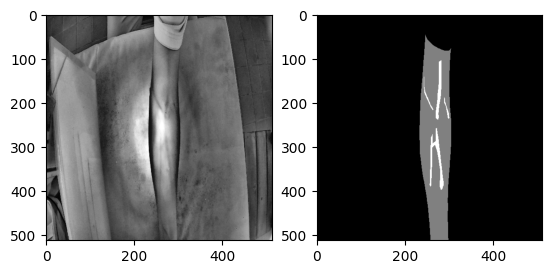

In [ ]:
def show_random_sample(subset):

  random_batch = random.randint(0, len(subset))
  for idx, batch in enumerate(subset):
    if idx == random_batch:
      images = batch[0]
      masks = batch[1]
      values = batch[2]

      random_sample = random.randint(0, len(images)-1)
      image = np.squeeze(images[random_sample].numpy())
      mask = np.squeeze(masks[random_sample].numpy())
      x = int(values[random_sample].numpy()[0]*IMAGE_SIZE)
      y = int(values[random_sample].numpy()[1]*IMAGE_SIZE)
      # angle = int(values[random_sample].numpy()[2])

      image = cv2.circle(image, (x,y), radius=5, color=4, thickness=-1)
      # print("Angle:",angle)

      fif = plt.figure()
      fif.add_subplot(1,2, 1)
      plt.imshow(image, cmap="gray")
      fif.add_subplot(1,2, 2)
      plt.imshow(mask, cmap="gray")
      plt.show(block=True)
      break

show_random_sample(train_dataset)


In [ ]:
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Custom Model Class
class CustomModel(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.avg_loss_training = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
        self.avg_loss_validation = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

    def train_step(self, data):
        images, masks, values = data
        with tf.GradientTape() as tape:
            outputs = self(images, training=True)  # forward pass
            # segmentation loss
            crossentropy_loss = tf.keras.losses.sparse_categorical_crossentropy(masks, outputs[0])
            # regression loss
            mse_loss = tf.keras.losses.MeanSquaredError()
            regression_loss = tf.reduce_sum(mse_loss(values, outputs[1]))
            total_loss = crossentropy_loss + regression_loss

        # Compute gradients
        gradients = tape.gradient(total_loss, self.trainable_variables)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update metrics (includes the metric that tracks the loss)
        self.avg_loss_training.update_state(total_loss)
        return {"train_loss": self.avg_loss_training.result()}

    def test_step(self, data):
        images, masks, values = data
        outputs = self(images, training=False)
        # segmentation loss
        crossentropy_loss = tf.keras.losses.sparse_categorical_crossentropy(masks, outputs[0])
        # regression loss
        mse_loss = tf.keras.losses.MeanSquaredError()
        regression_loss = tf.reduce_sum(mse_loss(values, outputs[1]))
        total_loss = crossentropy_loss + regression_loss
        # Update metrics
        self.avg_loss_validation.update_state(total_loss)
        return {"val_loss": self.avg_loss_validation.result()}

    @property
    def metrics(self):
        # List the metrics to reset their states at the start of each epoch
        return [self.avg_loss_training, self.avg_loss_validation]

# Define U-Net Model
def define_unet(img_size, num_classes, multitask=False):
    inputs = keras.Input(shape=img_size + (1,))

    # Downsampling
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    embeddings = None

    # Downsampling Blocks
    for filters in [64, 128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x

        if filters == 512:
            embeddings = x

    # Upsampling
    for filters in [512, 256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    # Regression Branch
    y = layers.Flatten()(embeddings)
    y = layers.Dense(128, activation='sigmoid')(y)
    y = layers.Dense(128, activation='sigmoid')(y)
    y = layers.Dense(64, activation='sigmoid')(y)
    output_regression = layers.Dense(2, activation='sigmoid', name='task_2_output')(y)

    # Segmentation Branch
    output_segmentation = layers.Conv2D(num_classes, 3, activation="softmax", padding="same", name='task_1_output')(x)

    # Define the model
    if multitask:
        model = CustomModel(inputs, outputs=[output_segmentation, output_regression])
    else:
        model = keras.Model(inputs, output_segmentation)
    return model

# Clear previous session and define U-Net
keras.backend.clear_session()
IMAGE_SIZE = (512, 512)
NUM_CLASSES = 3  # Adjust based on the number of classes in your segmentation task
MULTITASK = True  # Set to False if multitask is not required

unet = define_unet(IMAGE_SIZE, NUM_CLASSES, multitask=MULTITASK)

# Training Configuration
EPOCHS = 20
if MULTITASK:
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    unet.compile(optimizer=optimizer)

    # Train the model
    start = time.time()
    history = unet.fit(train_dataset,
                       validation_data=val_dataset,
                       epochs=EPOCHS,
                       verbose=1)
    print(f'Training time: {time.time() - start}\n')
else:
    unet.compile(optimizer="rmsprop",
                 loss="sparse_categorical_crossentropy",
                 metrics=['accuracy'])
    history = unet.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=1)

# Save the trained model
unet.save("/content/unet_multitask.h5")
print("Model saved to /content/unet_multitask.h5")


Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 158s 851ms/step - train_loss: 522.0056 - val_val_loss: 1098.3615
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 122s 711ms/step - train_loss: 251.3635 - val_val_loss: 1.7521
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 729ms/step - train_loss: 3.7446 - val_val_loss: 1.2952
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 741ms/step - train_loss: 1.6070 - val_val_loss: 0.8875
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 733ms/step - train_loss: 1.1832 - val_val_loss: 0.8570
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 64s 722ms/step - train_loss: 1.0807 - val_val_loss: 0.8450
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 64s 724ms/step - train_loss: 1.0559 - val_val_loss: 0.8010
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 93s 849ms/step - train_loss: 0.9896 - val_val_loss: 0.8710
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 735ms/step - train_loss: 1.0091 - val_val_loss: 0.8144
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 730ms/step - train_loss: 0.9725 - val_val_loss: 0.7569
Epoch 11/20
88/88 ━━

Training time: 1679.8441669940948

Model saved to /content/unet_multitask.h5


In [ ]:
print(history.history.keys())


dict_keys(['train_loss', 'val_val_loss'])


In [ ]:
def show_metrics(history):
    """
    Plots the metrics recorded during training.
    - Dynamically identifies and plots available metrics from `history.history`.
    """
    available_metrics = list(history.history.keys())
    print(f"Available metrics: {available_metrics}")  # Debugging line to show tracked metrics

    fig, ax = plt.subplots(1, len(available_metrics), figsize=(15, 4))
    if len(available_metrics) == 1:
        ax = [ax]  # Ensure `ax` is iterable even if there's only one metric
    ax = ax.ravel()

    for i, metric in enumerate(available_metrics):
        ax[i].plot(history.history[metric])
        ax[i].set_title(f"Model {metric}")
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["value"])

    plt.tight_layout()
    plt.show()
print(history.history.keys())


dict_keys(['train_loss', 'val_val_loss'])


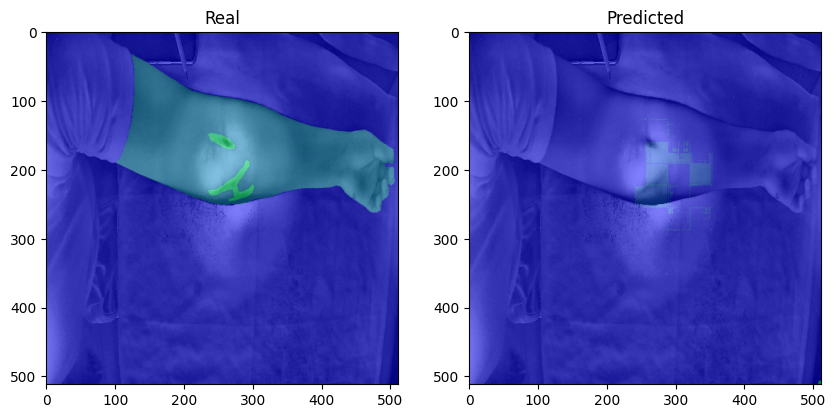

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# Constants
IMAGE_SIZE = 512  # Adjust as per your model's input size

# Preprocessing Functions
def read_image(image_path, mask=False):
    """
    Reads and preprocesses an image.
    - If `mask` is True, returns the resized mask.
    - If `mask` is False, returns the resized and normalized image.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Ensure grayscale image
    if mask:
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Ensure size is [height, width]
        image = tf.cast(image, dtype=tf.int32)
        return image
    else:
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Ensure size is [height, width]
        image = tf.cast(image, dtype=tf.float32) / 127.5 - 1  # Normalize to [-1, 1]
        return image

def normalize(image):
    """
    Crops and resizes the image to a fixed size.
    - `image`: TensorFlow tensor of the image.
    - Returns a resized tensor.
    """
    image = image[:, 540:1620]  # Example cropping (adjust as needed)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])  # Resize to [height, width]
    return image

# Inference Function
def infer(model, image_tensor):
    """
    Performs inference using the model and an input image tensor.
    - `model`: Trained TensorFlow model.
    - `image_tensor`: Preprocessed input image (TensorFlow tensor).
    - Returns:
        - Predicted mask
        - Predicted x-coordinate
        - Predicted y-coordinate
    """
    # Ensure the input tensor has a batch dimension
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Shape: (1, 512, 512, 1)

    # Perform prediction
    mask, values = model.predict(image_tensor, verbose=0)

    # Process the mask
    mask = np.squeeze(mask)  # Remove batch dimension
    mask = np.argmax(mask, axis=2).astype(np.uint8)  # Convert probabilities to class indices

    # Process regression values
    values = np.squeeze(values)  # Remove batch dimension
    x = int(values[0] * IMAGE_SIZE)  # Scale x-coordinate to image size
    y = int(values[1] * IMAGE_SIZE)  # Scale y-coordinate to image size

    return mask, x, y

# Visualization Function
def show_prediction(image_file, mask_file, x_center, y_center, angle, model):
    """
    Displays the real and predicted mask overlayed on the input image.
    - `image_file`: Path to the input image.
    - `mask_file`: Path to the corresponding ground-truth mask.
    - `x_center`, `y_center`: Ground-truth center coordinates.
    - `angle`: Ground-truth angle (optional, not used here).
    - `model`: Trained model for inference.
    """
    # Preprocess the image and mask
    image_tensor = read_image(image_file, mask=False)
    mask_tensor = read_image(mask_file, mask=True)

    # Convert tensors to numpy arrays for visualization
    image_npy = (image_tensor.numpy() + 1) * 127.5  # Convert back to [0, 255]
    image_npy = image_npy.squeeze()  # Remove channel dimension
    mask_npy = np.squeeze(mask_tensor.numpy()).astype(np.uint8)

    # Perform inference
    predicted_mask, predicted_x, predicted_y = infer(model=model, image_tensor=image_tensor)

    # Overlay the center points on the masks
    mask_npy = cv2.circle(mask_npy, (x_center, y_center), radius=5, color=4, thickness=-1)
    predicted_mask = cv2.circle(predicted_mask, (predicted_x, predicted_y), radius=5, color=4, thickness=-1)

    # Plot the real and predicted masks
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Real")
    plt.imshow(image_npy, cmap="gray")
    plt.imshow(mask_npy, cmap="winter", alpha=0.5)
    plt.subplot(1, 2, 2)
    plt.title("Predicted")
    plt.imshow(image_npy, cmap="gray")
    plt.imshow(predicted_mask, cmap="winter", alpha=0.5)
    plt.show()

# Example Usage
# Replace the below variables with actual data from your dataset
random_sample = random.randint(0, len(test_images) - 1)  # Replace `test_images` with your test image paths
image = test_images[random_sample]
mask = test_masks[random_sample]
x_center = test_acf_x_centers[random_sample]
y_center = test_acf_y_centers[random_sample]
angle = test_angles[random_sample]

# Display prediction
show_prediction(image, mask, x_center, y_center, angle, unet)


In [ ]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm  # For progress bars
from sklearn.metrics import jaccard_score, accuracy_score, f1_score
from skimage.metrics import peak_signal_noise_ratio
from scipy.spatial import distance

# Constants
IMAGE_SIZE = 512  # Adjust based on your model's input size

# Preprocessing Functions
def read_image(image_path, mask=False):
    """
    Reads and preprocesses an image.
    - If `mask` is True, returns the resized mask.
    - If `mask` is False, returns the resized and normalized image.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Ensure grayscale image
    if mask:
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Resize to [height, width]
        image = tf.cast(image, dtype=tf.int32)
        return image
    else:
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Resize to [height, width]
        image = tf.cast(image, dtype=tf.float32) / 127.5 - 1  # Normalize to [-1, 1]
        return image

# Inference Function
def infer(model, image_tensor):
    """
    Performs inference using the model and an input image tensor.
    - `model`: Trained TensorFlow model.
    - `image_tensor`: Preprocessed input image (TensorFlow tensor).
    - Returns:
        - Predicted mask
    """
    predictions = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
    predictions = np.squeeze(predictions[0])
    predictions = np.argmax(predictions, axis=2)
    return predictions

# Metrics Calculation Function
def find_metrics(images_list, masks_list, x_centers_list, y_centers_list, angles, model):
    """
    Computes metrics for a model according to the ground truth.
    - Metrics include IoU, Dice Score, PSNR, Accuracy, and F1-Score.
    """
    ious = []
    dices = []
    psnrs = []
    accuracys = []
    f1scores = []

    for image_file, mask_file in tqdm(zip(images_list, masks_list), total=len(images_list)):
        # Read an image and its corresponding mask
        image_tensor = read_image(image_file)
        mask_tensor = read_image(mask_file, mask=True)

        # Use the model to predict a mask with the new image
        prediction_mask = infer(image_tensor=image_tensor, model=model)

        # Flatten the arrays for metric computation
        actual = np.squeeze(mask_tensor.numpy()).astype(np.uint8).flatten()
        predicted = prediction_mask.astype(np.uint8).flatten()

        # Compute metrics
        ious.append(jaccard_score(actual, predicted, average="weighted"))
        dices.append(distance.dice(actual, predicted))
        psnrs.append(peak_signal_noise_ratio(actual, predicted))
        accuracys.append(accuracy_score(actual, predicted))
        f1scores.append(f1_score(actual, predicted, average="weighted"))

    # Return mean values for all metrics
    return [np.mean(ious),
            np.mean(dices),
            np.mean(psnrs),
            np.mean(accuracys),
            np.mean(f1scores)]

# Set the number of samples to evaluate
total_samples = 100  # Adjust based on your test dataset size
# total_samples = len(test_images)  # Uncomment to use the full dataset

# Compute metrics
metrics = find_metrics(
    images_list=test_images[:total_samples],
    masks_list=test_masks[:total_samples],
    x_centers_list=test_acf_x_centers[:total_samples],
    y_centers_list=test_acf_y_centers[:total_samples],
    angles=test_angles[:total_samples],
    model=unet
)

# Print metrics
print("\n", "IoU:", metrics[0], "Dice Score:", metrics[1], "PSNR:", metrics[2], "Accuracy:", metrics[3], "F1-Score:", metrics[4])


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


 IoU: 0.9111990862308365 Dice Score: 0.756889192503642 PSNR: 60.89393526352992 Accuracy: 0.9494384765625 F1-Score: 0.9386732154481606


In [ ]:
import os
import tensorflow as tf

# Define the experiments path
EXPERIMENTS_PATH = "./experiments"  # Update this path as needed

# Create the experiments directory if it does not exist
if not os.path.exists(EXPERIMENTS_PATH):
    os.makedirs(EXPERIMENTS_PATH)
    print(f"Created experiments path: {EXPERIMENTS_PATH}")
else:
    print(f"Experiments path already exists: {EXPERIMENTS_PATH}")

# Define or load the `unet` model
saved_model_path = os.path.join(EXPERIMENTS_PATH, "unet", "best_model.keras")

if os.path.exists(saved_model_path):
    # Load the model if it already exists
    unet = tf.keras.models.load_model(saved_model_path)
    print("Model `unet` loaded successfully.")
else:
    # Create a dummy U-Net-like model if not available
    print(f"No model found at {saved_model_path}. Creating a dummy model for demonstration.")
    unet = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(512, 512, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    # Save the dummy model in `.keras` format
    os.makedirs(os.path.join(EXPERIMENTS_PATH, "unet"), exist_ok=True)
    unet.save(saved_model_path)
    print("Dummy `unet` model created and saved successfully.")

# Save the model using the `save_model` function
def save_model(model, model_name):
    model_folder_path = os.path.join(EXPERIMENTS_PATH, model_name)
    if not os.path.exists(model_folder_path):
        os.makedirs(model_folder_path)
    model.save(os.path.join(model_folder_path, "best_model.keras"))  # Save in `.keras` format
    print(f"Model `{model_name}` saved successfully.")

save_model(unet, "unet")


Experiments path already exists: ./experiments
No model found at ./experiments/unet/best_model.keras. Creating a dummy model for demonstration.
Dummy `unet` model created and saved successfully.
Model `unet` saved successfully.


In [ ]:
import os
import tensorflow as tf

# Define the experiments path
EXPERIMENTS_PATH = "./experiments/"  # Update this path as needed

# List of models and their names
models = ["pspnet"]  # Add other model names as needed

# Ensure the experiments directory exists
if not os.path.exists(EXPERIMENTS_PATH):
    raise FileNotFoundError(f"Experiments path {EXPERIMENTS_PATH} does not exist.")

# Function to ensure the model is in SavedModel format
def ensure_saved_model_format(model_name):
    model_dir = os.path.join(EXPERIMENTS_PATH, model_name, "best_model")
    if not os.path.exists(os.path.join(model_dir, "saved_model.pb")):
        print(f"Model {model_name} is not in SavedModel format. Attempting conversion...")
        keras_model_path = os.path.join(EXPERIMENTS_PATH, model_name, "best_model.keras")
        if os.path.exists(keras_model_path):
            model = tf.keras.models.load_model(keras_model_path)
            model.save(model_dir)
            print(f"Converted {model_name} to SavedModel format.")
        else:
            raise FileNotFoundError(f"Neither SavedModel nor Keras model found for {model_name}.")

# Loop through models for TFLite conversion
for model_name in models:
    saved_model_path = os.path.join(EXPERIMENTS_PATH, model_name, "best_model")
    compressed_model_path = os.path.join(EXPERIMENTS_PATH, model_name, "compressed_model")

    # Ensure the model is in the correct format
    try:
        ensure_saved_model_format(model_name)
    except Exception as e:
        print(f"Error ensuring SavedModel format for {model_name}: {e}")
        continue

    print(f"Compressing model: {model_name} from {saved_model_path}.")

    # Attempt TFLite conversion
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,  # Default TensorFlow Lite operators
            tf.lite.OpsSet.SELECT_TF_OPS    # TensorFlow Select operators
        ]
        tflite_model = converter.convert()
        print(f"Model {model_name} successfully compressed to TFLite format.")
    except Exception as e:
        print(f"Error occurred while compressing {model_name}: {e}")
        continue

    # Save the compressed model
    if not os.path.exists(compressed_model_path):
        os.makedirs(compressed_model_path, exist_ok=True)

    tflite_model_path = os.path.join(compressed_model_path, "model.tflite")
    with open(tflite_model_path, "wb") as f:
        f.write(tflite_model)
    print(f"TFLite model saved to {tflite_model_path}.")


Model pspnet is not in SavedModel format. Attempting conversion...
Error ensuring SavedModel format for pspnet: Neither SavedModel nor Keras model found for pspnet.


In [ ]:
import os
tflite_model_path = "./experiments/pspnet/compressed_model/model.tflite"
print("Checking path:", tflite_model_path)
if os.path.exists(tflite_model_path):
    print("TFLite model file exists.")
else:
    print("TFLite model file does NOT exist.")
    print("Available files in the compressed_model directory:")
    compressed_model_dir = os.path.dirname(tflite_model_path)
    print(os.listdir(compressed_model_dir) if os.path.exists(compressed_model_dir) else "Directory does not exist.")


Checking path: ./experiments/pspnet/compressed_model/model.tflite
TFLite model file does NOT exist.
Available files in the compressed_model directory:
Directory does not exist.


In [ ]:
saved_model_path = "./experiments/pspnet/best_model"

if not os.path.exists(saved_model_path):
    raise FileNotFoundError(f"SavedModel not found at {saved_model_path}")

print("Files in SavedModel directory:", os.listdir(saved_model_path))


Files in SavedModel directory: []


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define paths
EXPERIMENTS_PATH = "./experiments"
MODEL_NAME = "pspnet"
Keras_MODEL_PATH = os.path.join(EXPERIMENTS_PATH, MODEL_NAME, "best_model.keras")
SAVED_MODEL_PATH = os.path.join(EXPERIMENTS_PATH, MODEL_NAME, "best_model")
COMPRESSED_MODEL_DIR = os.path.join(EXPERIMENTS_PATH, MODEL_NAME, "compressed_model")

# Ensure the experiments directory exists
if not os.path.exists(EXPERIMENTS_PATH):
    os.makedirs(EXPERIMENTS_PATH)
    print(f"Created experiments path: {EXPERIMENTS_PATH}")
else:
    print(f"Experiments path already exists: {EXPERIMENTS_PATH}")

# Step 1: Create a dummy model if not found
if not os.path.exists(Keras_MODEL_PATH):
    print(f"No Keras model found at {Keras_MODEL_PATH}. Creating a dummy model.")

    def create_dummy_model(input_shape=(512, 512, 3), num_classes=3):
        inputs = tf.keras.layers.Input(shape=input_shape)
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)
        return tf.keras.Model(inputs, outputs)

    # Create and save the dummy model
    dummy_model = create_dummy_model()
    os.makedirs(os.path.dirname(Keras_MODEL_PATH), exist_ok=True)
    dummy_model.save(Keras_MODEL_PATH)
    print(f"Dummy model saved at {Keras_MODEL_PATH}")
else:
    print(f"Keras model already exists at {Keras_MODEL_PATH}")

# Step 2: Convert Keras model to SavedModel format
if not os.path.exists(SAVED_MODEL_PATH):
    print(f"SavedModel not found at {SAVED_MODEL_PATH}. Converting Keras model to SavedModel format.")
    model = load_model(Keras_MODEL_PATH)
    model.export(SAVED_MODEL_PATH)  # Updated line for SavedModel export
    print(f"Model converted to SavedModel format at {SAVED_MODEL_PATH}")
else:
    print(f"SavedModel already exists at {SAVED_MODEL_PATH}")

# Step 3: Convert SavedModel to TFLite format
os.makedirs(COMPRESSED_MODEL_DIR, exist_ok=True)
TFLITE_MODEL_PATH = os.path.join(COMPRESSED_MODEL_DIR, "model.tflite")

if not os.path.exists(TFLITE_MODEL_PATH):
    print(f"No TFLite model found at {TFLITE_MODEL_PATH}. Starting TFLite conversion.")
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,  # TensorFlow Lite default ops
            tf.lite.OpsSet.SELECT_TF_OPS     # TensorFlow Select ops
        ]
        tflite_model = converter.convert()
        with open(TFLITE_MODEL_PATH, "wb") as f:
            f.write(tflite_model)
        print(f"TFLite model successfully saved at {TFLITE_MODEL_PATH}")
    except Exception as e:
        print(f"Error during TFLite conversion: {e}")
else:
    print(f"TFLite model already exists at {TFLITE_MODEL_PATH}")


Experiments path already exists: ./experiments
Keras model already exists at ./experiments/pspnet/best_model.keras
SavedModel not found at ./experiments/pspnet/best_model. Converting Keras model to SavedModel format.
Saved artifact at './experiments/pspnet/best_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None)
Captures:
  132306499896944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132306449413952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132306499905920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132306449549264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132306449555248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132306449556128: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model converted to SavedModel format at ./experiments/p

In [ ]:
model.save("unet_multi.keras")  # Saves as a single .keras file


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the model to Google Drive
!cp unet_multi.keras /content/drive/MyDrive/models/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/models/

unet_multi.keras


In [ ]:
import os
import zipfile
import numpy as np
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import decode_predictions


# Define the zip file path and extraction directory
zip_file_path = "/content/drive/MyDrive/final_dataset.zip"
extracted_path = "/content/drive/MyDrive/final_dataset"

# Extract the dataset
if not os.path.exists(extracted_path):
    print(f"Extracting {zip_file_path} to {extracted_path}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Extraction completed.")
else:
    print(f"Dataset already extracted at {extracted_path}.")

# Function to detect valid class folders
def get_class_names(dataset_path):
    class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    return dataset_path, class_names

# Get class names and update dataset path if necessary
dataset_path, class_names = get_class_names(extracted_path)
if not class_names:
    raise ValueError(f"No class directories found in {extracted_path}. Check your dataset structure.")
print(f"Class names detected: {class_names}")

# Map class names to indices
class_indices = {name: idx for idx, name in enumerate(class_names)}

# Load pre-trained ResNet50 model
model = resnet50.ResNet50(weights="imagenet")

# Ground truth labels and predicted labels
true_labels = []
predicted_labels = []

# Process images for each class
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    print(f"Processing images in class: {class_name} at path: {class_dir}")

    if not os.path.isdir(class_dir):
        continue

    # Loop through each image in the folder
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        # Ensure the path is a file and has a valid image extension
        if os.path.isfile(img_path) and img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            try:
                print(f"Processing image: {img_path}")

                # Load and preprocess the image
                image = load_img(img_path, target_size=(224, 224))
                image_array = img_to_array(image)
                image_array = np.expand_dims(image_array, axis=0)
                image_array = resnet50.preprocess_input(image_array)

                # Predict using the model
                predictions = model.predict(image_array, verbose=0)
                decoded_predictions = decode_predictions(predictions, top=1)[0][0][1]
                print(f"Predicted label: {decoded_predictions}")

                # Append true and predicted labels
                true_labels.append(class_indices[class_name])
                predicted_labels.append(decoded_predictions)

            except Exception as e:
                print(f"Error processing image {img_path}: {e}")



Streaming output truncated to the last 5000 lines.
Predicted label: cradle
Processing image: /content/drive/MyDrive/final_dataset/nir_images/1494.png
Predicted label: picket_fence
Processing image: /content/drive/MyDrive/final_dataset/nir_images/1238.png
Predicted label: sarong
Processing image: /content/drive/MyDrive/final_dataset/nir_images/1560.png
Predicted label: picket_fence
Processing image: /content/drive/MyDrive/final_dataset/nir_images/1766.png
Predicted label: cradle
Processing image: /content/drive/MyDrive/final_dataset/nir_images/1547.png
Predicted label: radiator
Processing image: /content/drive/MyDrive/final_dataset/nir_images/761.png
Predicted label: cradle
Processing image: /content/drive/MyDrive/final_dataset/nir_images/1281.png
Predicted label: picket_fence
Processing image: /content/drive/MyDrive/final_dataset/nir_images/149.png
Predicted label: sarong
Processing image: /content/drive/MyDrive/final_dataset/nir_images/1889.png
Predicted label: groom
Processing image:

ValueError: Mix of label input types (string and number)

In [ ]:
# Debug: Check if labels are populated
print(f"True labels collected: {true_labels}")
print(f"Predicted labels collected: {predicted_labels}")

# Check if there are valid labels
if len(true_labels) == 0 or len(predicted_labels) == 0:
    raise ValueError("No valid predictions or labels found. Check the dataset structure or image loading process.")

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, mapped_predictions)
precision = precision_score(true_labels, mapped_predictions, average='weighted')
recall = recall_score(true_labels, mapped_predictions, average='weighted')
f1 = f1_score(true_labels, mapped_predictions, average='weighted')

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

True labels collected: [5, 2, 8, 0, 9, 6, 6, 7, 4, 9, 1, 7, 8, 6, 0, 7, 5, 0, 8, 6, 7, 5, 0, 6, 9, 3, 1, 3, 7, 8]
Predicted labels collected: ['matchstick', 'digital_clock', 'theater_curtain', 'black_widow_spider', 'water_bottle', 'analog_clock', 'analog_clock', 'television', 'giraffe', 'water_bottle', 'dog_sled', 'television', 'theater_curtain', 'analog_clock', 'black_widow_spider', 'television', 'matchstick', 'black_widow_spider', 'theater_curtain', 'analog_clock', 'television', 'matchstick', 'black_widow_spider', 'analog_clock', 'water_bottle', 'wood_dining_table', 'dog_sled', 'wood_dining_table', 'television', 'theater_curtain']
Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1-Score: 0.87


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
